# Spatial biases

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os

import dask
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
from cartopy import crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from dask.distributed import Client
from evaltools import obs
from evaltools.obs import eobs_mapping
from evaltools.utils import short_iid
from matplotlib.colors import BoundaryNorm
from tools import (
    check_equal_period,
    check_time,
    create_cordex_grid,
    e_obs_dic,
    fix_360_longitudes,
    height_temperature_correction,
    load_obs,
    mask_invalid,
    open_datasets,
    regrid_dsets,
    seasonal_mean,
    standardize_unit,
    var_dic,
    variable_mapping,
)

dask.config.set(scheduler="single-threaded")

In [ ]:
import dask

# make sure we don't fill up sys tmp
dask.config.set(
    temporary_directory=f"/mnt/CORDEX_CMIP6_tmp/user_tmp/{os.environ.get('USER')}/dask-tmp"
)
# no hyperthreading, netcdf is not threadsafe
client = Client(dashboard_address="localhost:8888", threads_per_worker=1)
client

In [4]:
from evaltools.source import xarray_open_kwargs

# creates chunksizes about 100MB
xarray_open_kwargs["chunks"] = {"time": 160}

In [5]:
variable = "tas"
frequency = "mon"
domain = "EUR-11"
regridding = "bilinear"
period_star = "1989"
period_stop = "2008"
parent = True

In [6]:
period = slice(period_star, period_stop)

In [7]:
save_results_path = os.path.abspath(
    os.path.join(os.getcwd(), "..", "intermediate-results")
)
save_figure_path = os.path.abspath(os.path.join(os.getcwd(), "..", "plots"))

In [8]:
rotated_grid = create_cordex_grid("EUR-11")  # No matter CMIP5 or CMIP6

## E-OBS is used as the reference dataset for all the analysis
It is used to calculate bias not only respect to CORDEX, but also in comparison wit other reanalyses and observational dataset, to assess the uncertaintly of the observational dataset

In [ ]:
# load, regrid and calculate seasonal means
eobs_var = [key for key, value in eobs_mapping.items() if value == variable][0]
eobs = obs.eobs(variables=eobs_var, add_mask=False).sel(time=period)
eobs = mask_invalid(eobs, vars=eobs_var, threshold=0.1)
eobs = eobs.rename({eobs_var: variable})
eobs = standardize_unit(eobs, variable)
# eobs = load_eobs(add_mask=False, to_cf=False, variable = variable)
# unmapped_to_nan, see https://github.com/pangeo-data/xESMF/issues/56
regridder = xe.Regridder(eobs, rotated_grid, method=regridding, unmapped_to_nan=True)
ref_on_rotated = regridder(eobs)
if not check_equal_period(ref_on_rotated, period):
    print(f"Temporal coverage of dataset does not match with {period}")
if not check_time(ref_on_rotated)["continuous"]:
    print("Time dimension is not continuois")
ref_seasmean = seasonal_mean(ref_on_rotated[variable].sel(time=period)).compute()

## CERRA and ERA5

In [ ]:
dsets = {}
for dset in var_dic[variable]["datasets"]:
    ds = load_obs(variable, dset, add_fx=True, mask=True)
    ds = ds.sel(time=period).compute()
    ds = fix_360_longitudes(ds, lonname="longitude")
    if not variable_mapping[dset][variable] == variable:
        ds = ds.rename_vars({variable_mapping[dset][variable]: variable})
    ds = standardize_unit(ds, variable)
    dsets[dset] = ds

In [11]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

In [12]:
for dset in dsets.keys():
    if not check_time(dsets[dset])["continuous"]:
        print(f"Time dimension is not continuois for {dset}")

Time dimension is not continuois for era5
Time dimension is not continuois for cerra


In [13]:
## regidding masking the data with the sftlf
for dset, ds in dsets.items():
    regridder = xe.Regridder(ds, rotated_grid, method=regridding, unmapped_to_nan=True)
    dsets[dset] = regridder(ds)

In [14]:
if variable == "tas":
    for dset in dsets:
        h_c = height_temperature_correction(dsets[dset].orog, ref_on_rotated.elevation)
        dsets[dset]["tas"] = dsets[dset].tas - h_c.fillna(0)

In [15]:
if var_dic[variable]["diff"] == "abs":
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
        - (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
elif var_dic[variable]["diff"] == "rel":
    diffs = {
        dset_id: 100
        * (seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean))
        / (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
obs_seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(map(lambda x: x, diffs.keys())),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

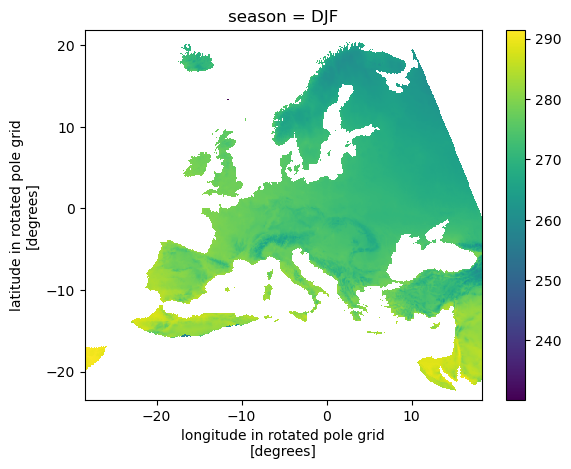

In [16]:
ref_seasmean.isel(season=0).plot()

# CMIP6

In [17]:
mip_era = "CMIP6"
driving_source_id = "ERA5"

In [ ]:
dsets = open_datasets(
    [variable],
    frequency=frequency,
    driving_source_id=driving_source_id,
    mask=True,
    add_missing_bounds=False,
)

In [ ]:
for k in dsets.keys():
    print(k)
    for var in dsets[k].variables:
        if var in ["orog", "sftlf"]:
            print(var)

In [20]:
for dset in dsets.keys():
    dsets[dset] = dsets[dset].sel(time=period)

In [21]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

In [22]:
for dset in dsets.keys():
    if not check_time(dsets[dset])["continuous"]:
        print(f"Time dimension is not continuois for {dset}")

In [23]:
for dset in dsets.keys():
    dsets[dset] = standardize_unit(dsets[dset], variable)

In [ ]:
rotated_grid = create_cordex_grid(domain)
dsets = regrid_dsets(dsets, rotated_grid, method=regridding)

In [25]:
if variable == "tas":
    for dset in dsets:
        h_c = height_temperature_correction(dsets[dset].orog, ref_on_rotated.elevation)
        dsets[dset]["tas"] = dsets[dset].tas - h_c.fillna(0)

In [ ]:
if var_dic[variable]["diff"] == "abs":
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
        - (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
elif var_dic[variable]["diff"] == "rel":
    diffs = {
        dset_id: 100
        * (seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean))
        / (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(
            map(
                lambda x: short_iid(
                    x, ["source_id", "version_realization"], delimiter="_"
                ),
                diffs.keys(),
            )
        ),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

In [27]:
seasonal_bias.to_netcdf(
    f"{save_results_path}/{variable}_{mip_era}_{period.start}-{period.stop}_spatial_bias.nc"
)

# CMIP5

In [28]:
mip_era = "CMIP5"
driving_source_id = "ERAINT"

In [ ]:
dsets = open_datasets(
    [variable],
    frequency="mon",
    driving_source_id=driving_source_id,
    mask=True,
    add_missing_bounds=False,
)

In [ ]:
dsets_day = open_datasets(
    [variable],
    frequency="day",
    source_id=["WRF381P", "HIRHAM5", "RegCM4-6"],
    driving_source_id=driving_source_id,
    mask=True,
    add_missing_bounds=False,
)

In [31]:
static_vars = ["orog", "sftlf", "areacella", "mask"]
## resample dset_day
dsets_mon = {}
for dset in dsets_day.keys():
    dsets_copy = dsets_day[dset].copy()
    ds_var_mon = dsets_copy[[variable]].resample(time="ME").mean()
    for var in static_vars:
        if var in dsets_copy.variables:
            ds_var_mon[var] = dsets_copy[var]

    dsets_mon[dset.replace(".day.", ".mon.")] = ds_var_mon

In [32]:
dsets = dsets | dsets_mon

In [ ]:
for k in dsets.keys():
    print(k)
    for var in dsets[k].variables:
        if var in ["orog", "sftlf"]:
            print(var)

In [34]:
for dset in dsets.keys():
    dsets[dset] = dsets[dset].sel(time=period)

In [35]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

In [36]:
for dset in dsets.keys():
    if not check_time(ref_on_rotated)["continuous"]:
        print(f"Time dimension is not continuois for {dset}")

In [37]:
for dset in dsets.keys():
    dsets[dset] = standardize_unit(dsets[dset], variable)

Convert celsius to kelvin


In [ ]:
rotated_grid = create_cordex_grid(domain)
dsets = regrid_dsets(dsets, rotated_grid, method=regridding)

In [39]:
if variable == "tas":
    for dset in dsets:
        h_c = height_temperature_correction(dsets[dset].orog, ref_on_rotated.elevation)
        dsets[dset]["tas"] = dsets[dset].tas - h_c.fillna(0)

In [ ]:
if var_dic[variable]["diff"] == "abs":
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
        - (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
elif var_dic[variable]["diff"] == "rel":
    diffs = {
        dset_id: 100
        * (seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean))
        / (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(
            map(
                lambda x: short_iid(
                    x, ["source_id", "version_realization"], delimiter="_"
                ),
                diffs.keys(),
            )
        ),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

In [42]:
seasonal_bias.to_netcdf(
    f"{save_results_path}/{variable}_{mip_era}_{period.start}-{period.stop}_spatial_bias.nc"
)

# Plot

In [43]:
CMIP6_seasonal_bias = xr.open_dataset(
    f"{save_results_path}/{variable}_CMIP6_{period.start}-{period.stop}_spatial_bias.nc"
)
CMIP5_seasonal_bias = xr.open_dataset(
    f"{save_results_path}/{variable}_CMIP5_{period.start}-{period.stop}_spatial_bias.nc"
)

In [44]:
eur_colors = pd.read_csv("eurocordex_models.csv")

In [45]:
projects = ["CMIP5", "CMIP6"]
models_cmip6 = eur_colors[eur_colors["mip_era"] == "CMIP6"].apply(
    lambda row: f"{row['model']}_{row['model_version']}", axis=1
)
parents_cmip6 = eur_colors[eur_colors["mip_era"] == "CMIP6"].apply(
    lambda row: f"{row['parent']}_{row['parent_version']}", axis=1
)
parents_cmip6[
    eur_colors[eur_colors["mip_era"] == "CMIP6"]["parent_mip_era"] == "CMIP6"
] = np.nan

In [46]:
if parent is True:

    parent_str = "parent"
    models = []
    for m5, m6 in zip(parents_cmip6, models_cmip6):
        models.append(f"cmip5_{m5}")
        models.append(f"cmip6_{m6}")
else:

    parent_str = "no-parent"
    models = []
    for m6 in models_cmip6:
        models.append(f"cmip6_{m6}")

models = [m for m in models if "_nan" not in m]
seen = set()
models = [m for m in models if not (m in seen or seen.add(m))]

In [ ]:
## include
model = "cmip6_HCLIM43-ALADIN_v1-r1"
new_models = ["cmip5_HIRHAM5_v1", "cmip5_RCA4_v1"]

if model in models:
    idx = models.index(model)
    models[idx + 1 : idx + 1] = new_models
print(models)

In [ ]:
models

In [49]:
seen = set()
models = [m for m in models if not (m in seen or seen.add(m))]

In [50]:
models_all = ["e-obs"] + obs_seasonal_bias.dset_id.values.tolist() + models

/tmp/ipykernel_2524121/3819085825.py:3: FutureWarning: This is a FutureWarning example
  warnings.warn("This is a FutureWarning example", FutureWarning)
/tmp/ipykernel_2524121/3819085825.py:168: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
/tmp/ipykernel_2524121/3819085825.py:168: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
/tmp/ipykernel_2524121/3819085825.py:168: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
/tmp/ipykernel_2524121/3819085825.py:168: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)


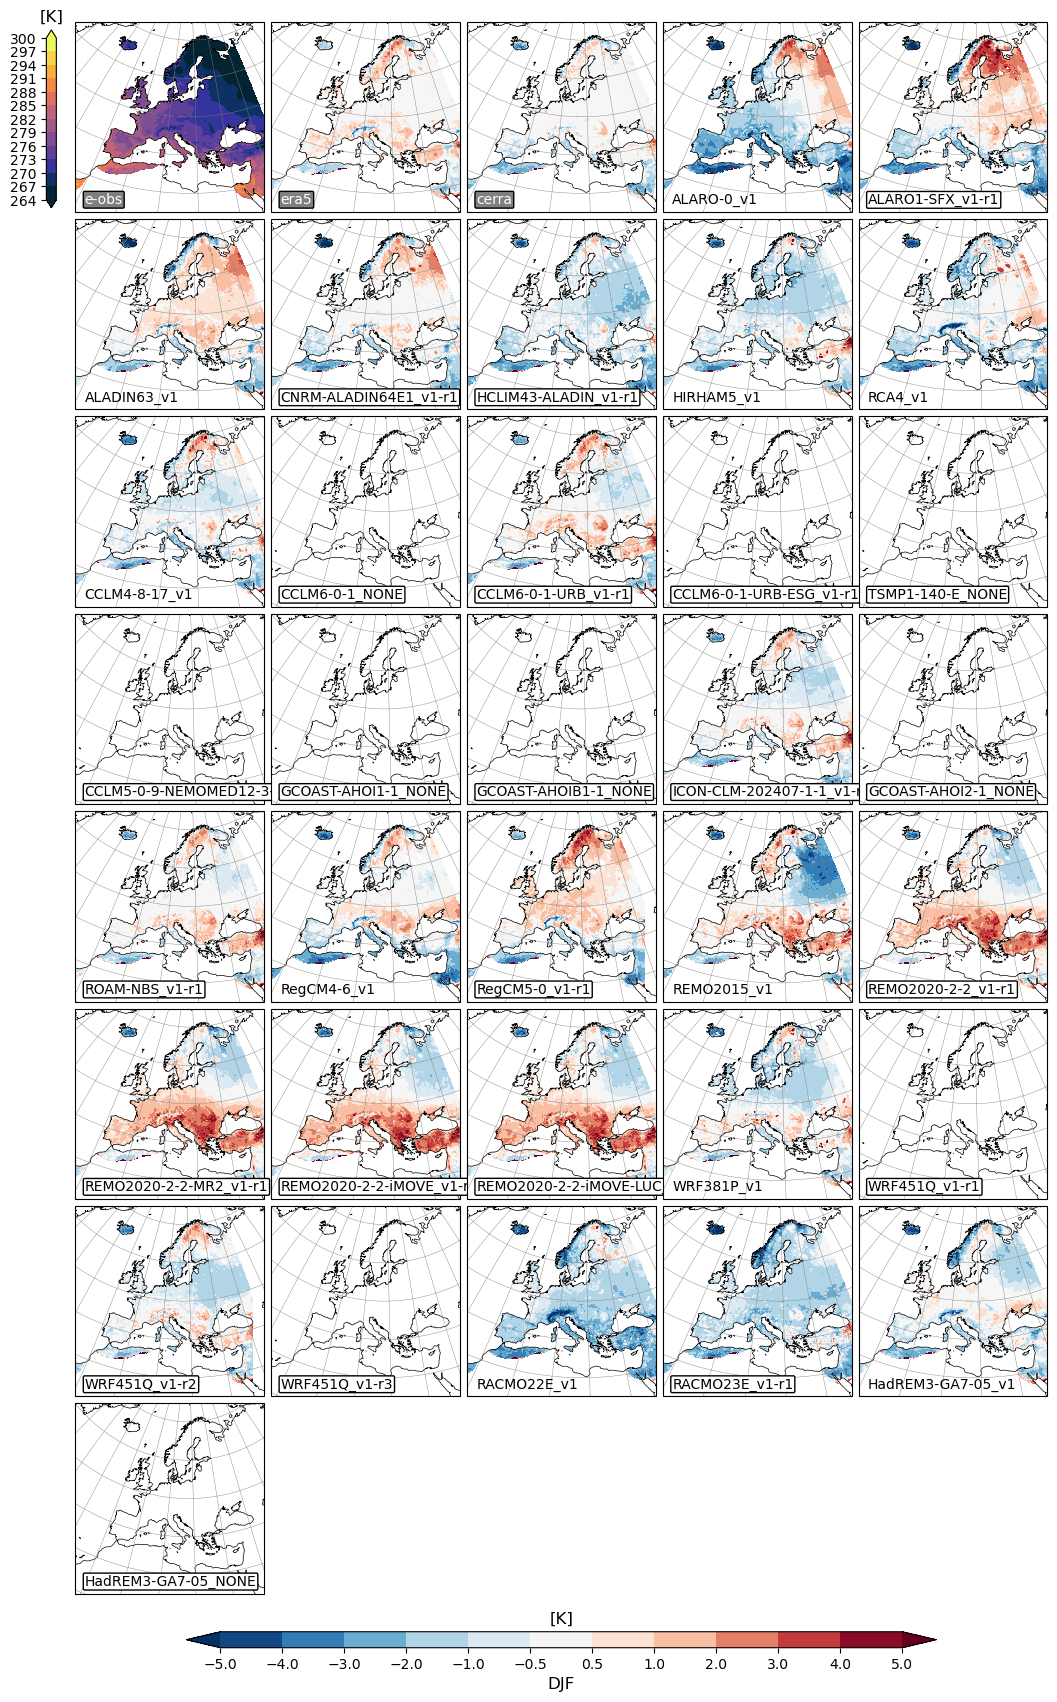

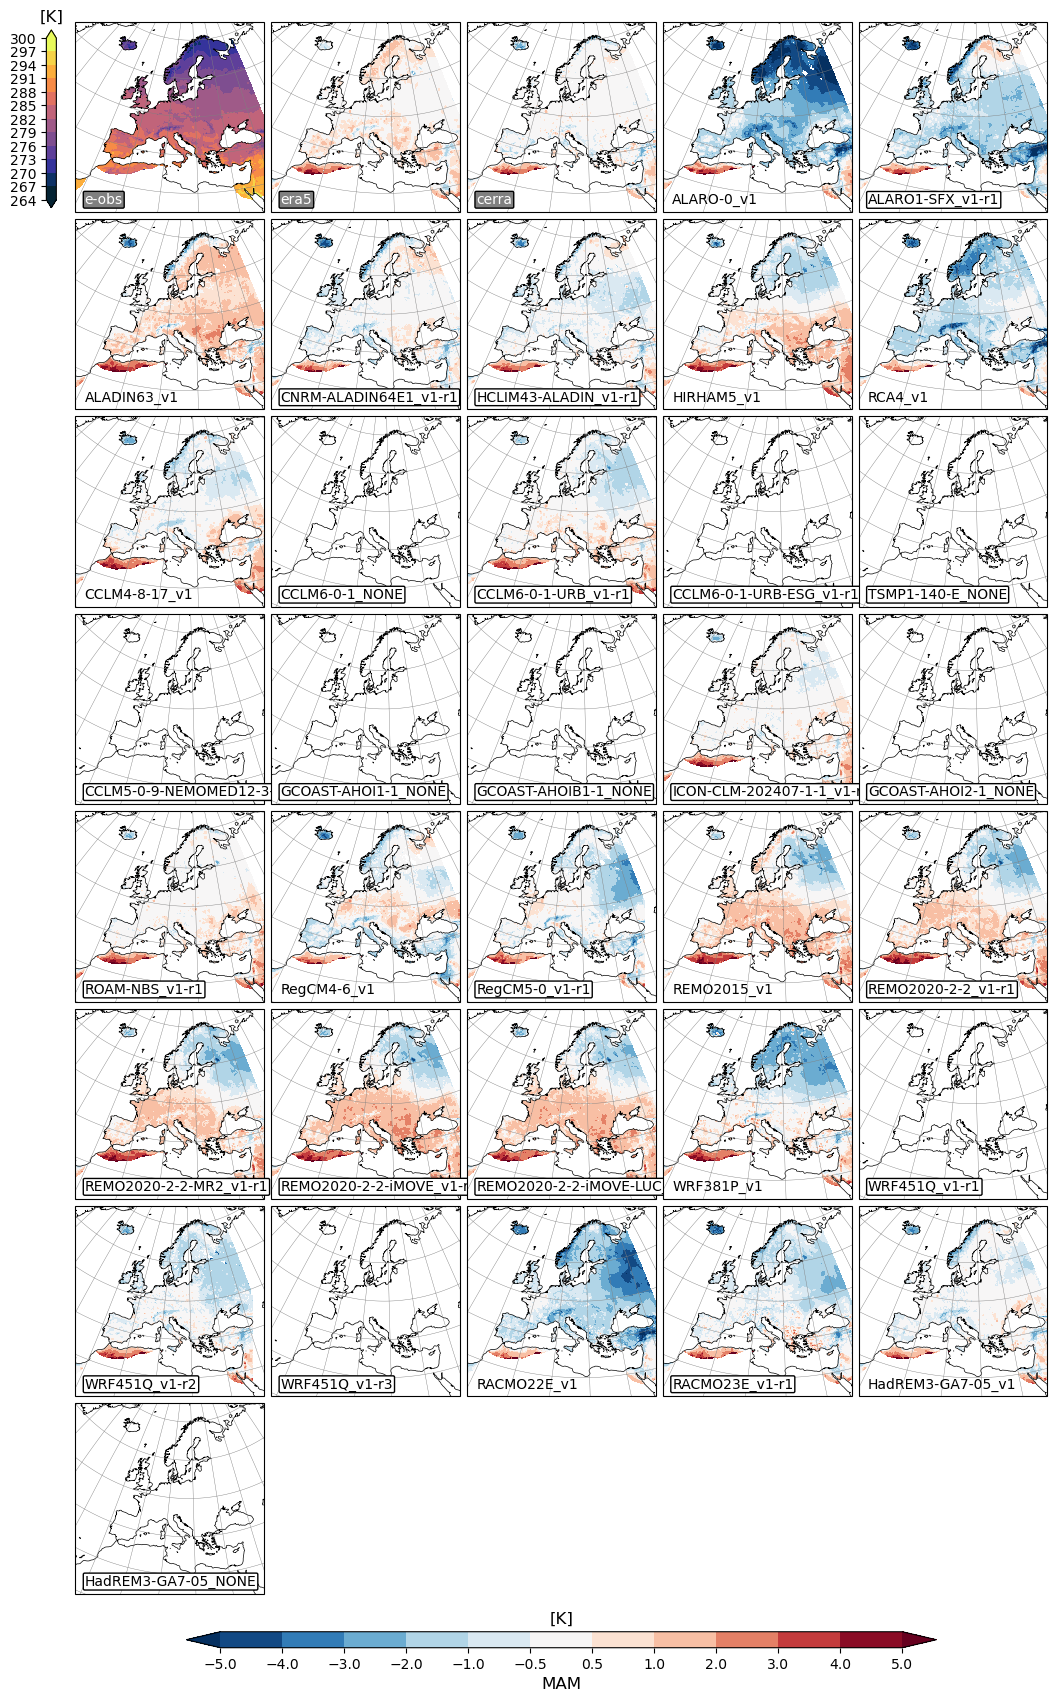

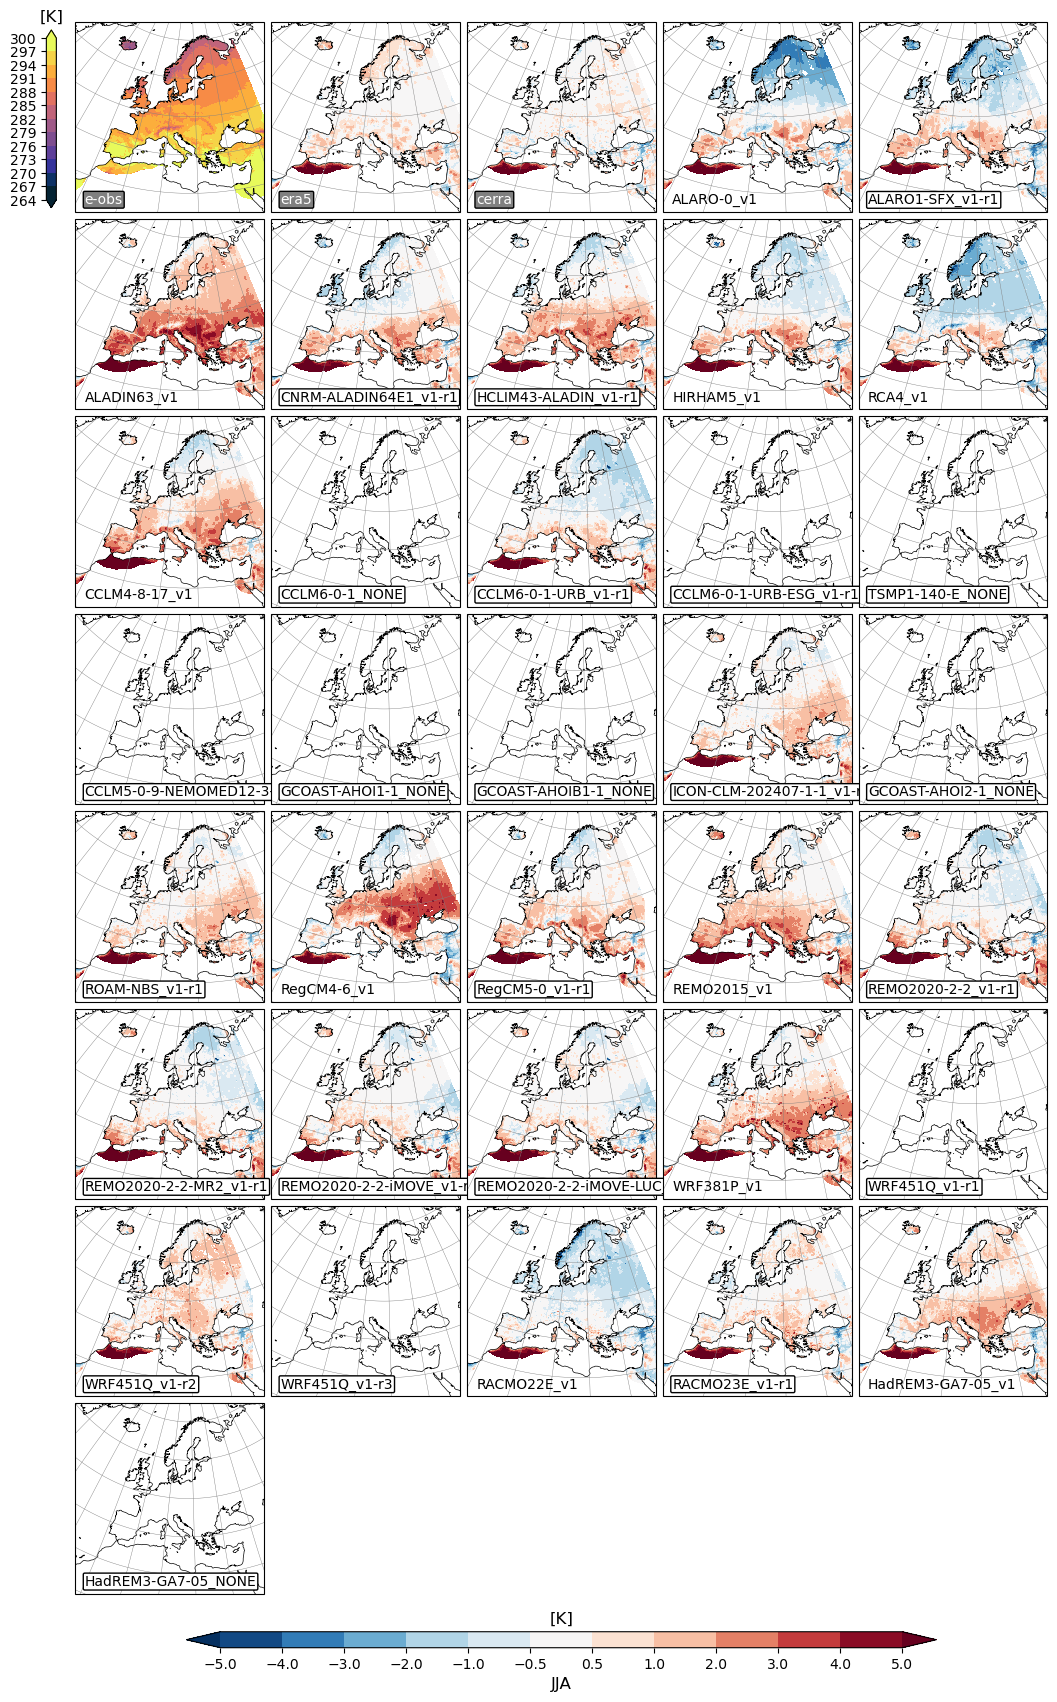

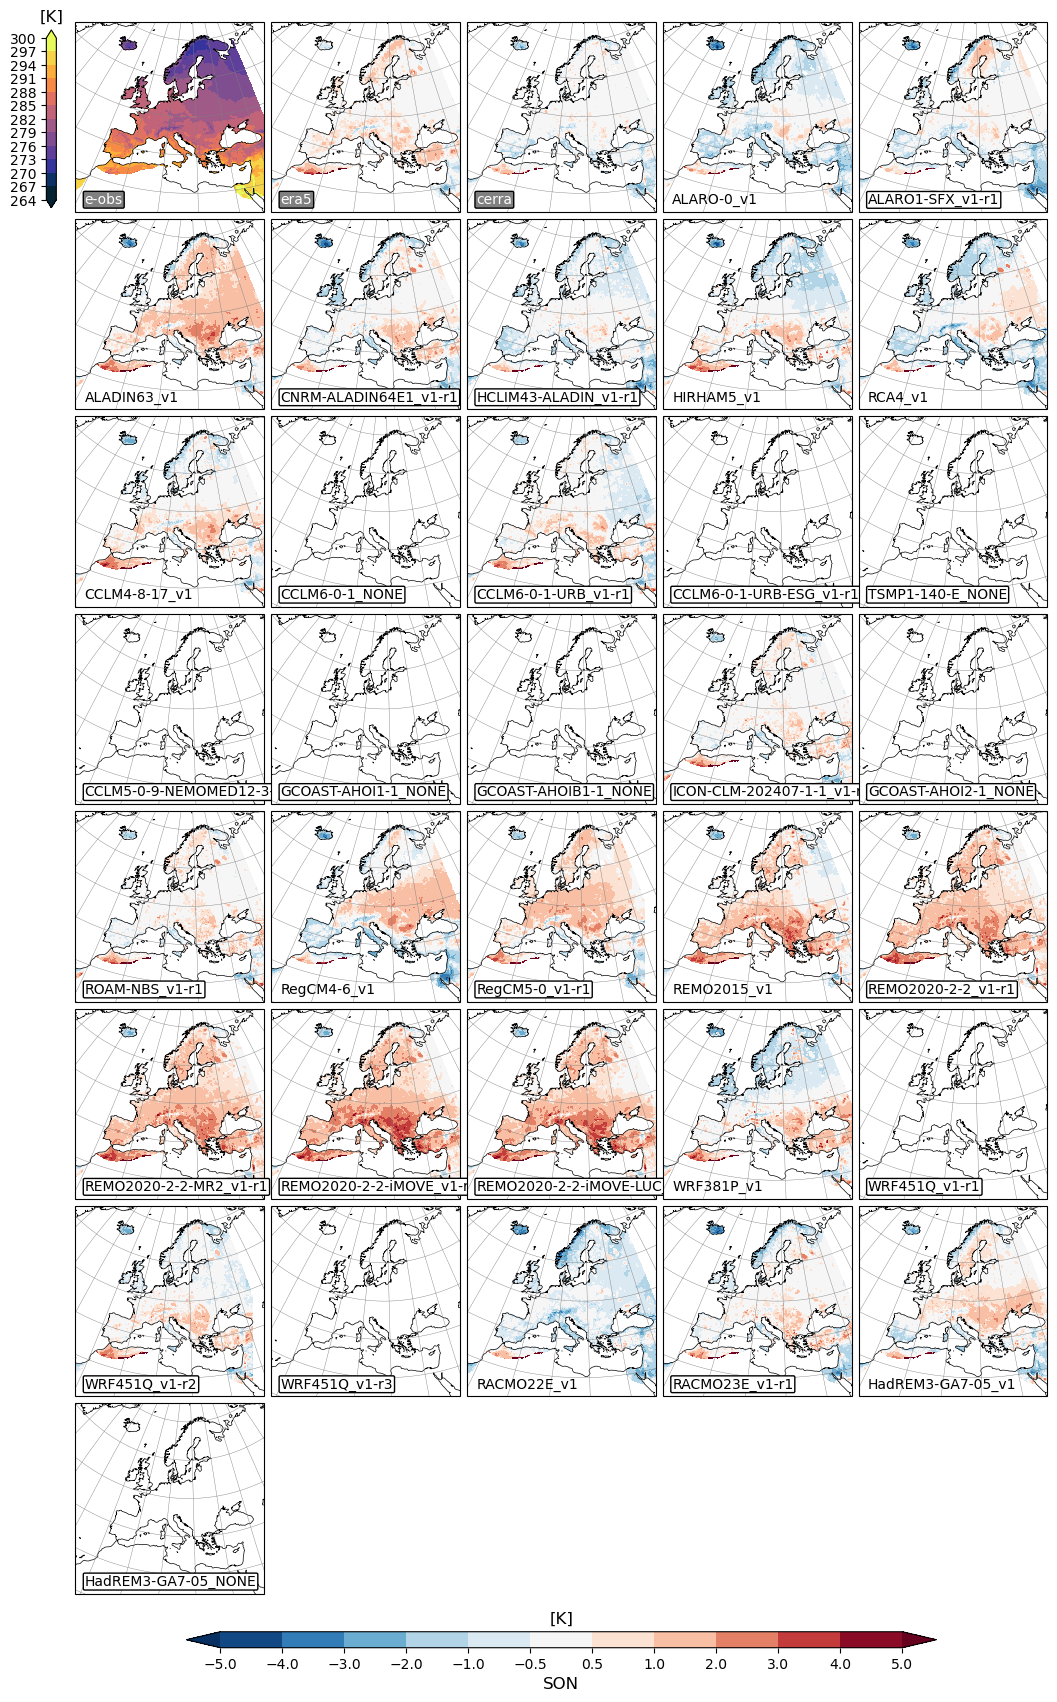

In [51]:
import warnings

warnings.warn("This is a FutureWarning example", FutureWarning)

for season in ["DJF", "MAM", "JJA", "SON"]:

    ncols = 5
    nrows = math.ceil(len(models_all) / ncols)
    transform = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162.0)
    projection = transform

    fig, axs = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        subplot_kw={"projection": projection},
        figsize=(ncols * 2, nrows * 2),
    )

    axs = axs.flatten()

    for n_m, model in enumerate(models_all):

        levels = var_dic[variable]["levels"]
        cmap = var_dic[variable]["cmap"]

        if "cmip5" in model:
            ds = CMIP5_seasonal_bias
            project = "cmip5"
            model = model.split(project + "_")[1]
        elif "cmip6" in model:
            ds = CMIP6_seasonal_bias
            project = "cmip6"
            model = model.split(project + "_")[1]
        elif "e-obs" == model:
            ds = ref_seasmean
            project = "e-obs"
            model = project
        else:
            ds = obs_seasonal_bias
            project = "obs"

        aspect = ds.cf.sizes["Y"] / ds.cf.sizes["X"]

        if project in ["obs", "cmip6", "cmip5"]:
            if model in ds.dset_id:
                data = (
                    ds[variable]
                    .isel(
                        season=np.where(ds.season == season)[0],
                        dset_id=np.where(ds.dset_id == model)[0],
                    )
                    .squeeze(dim=["season", "dset_id"])
                )
                cs = axs[n_m].contourf(
                    ds.cf["X"],
                    ds.cf["Y"],
                    data,
                    transform=transform,
                    levels=levels,
                    extend="both",
                    cmap=cmap,
                )
            else:
                cs = axs[n_m].contourf(
                    ds.cf["X"],
                    ds.cf["Y"],
                    data * np.nan,
                    transform=transform,
                    levels=levels,
                    extend="both",
                    cmap=cmap,
                )

        elif project == "e-obs":
            data = ds.isel(season=np.where(ds.season == season)[0]).squeeze(
                dim=["season"]
            )

            n_colors = len(e_obs_dic[variable]["levels"]) - 1
            # cmap_eobs = plt.get_cmap(e_obs_dic[variable]["cmap"], n_colors)
            if variable == "pr":
                data = data * 30.5
            colors = e_obs_dic[variable]["cmap"](np.linspace(0, 1, n_colors))
            cmap_eobs = mcolors.ListedColormap(colors)
            norm = BoundaryNorm(e_obs_dic[variable]["levels"], ncolors=n_colors)
            c1 = axs[n_m].contourf(
                ds.cf["X"],
                ds.cf["Y"],
                data,
                transform=transform,
                levels=e_obs_dic[variable]["levels"],
                extend="both",
                cmap=cmap_eobs,
                norm=norm,
            )

        axs[n_m].set_aspect(round(aspect, 3))
        axs[n_m].coastlines(resolution="50m", color="black", linewidth=0.5)

        gl = axs[n_m].gridlines(
            draw_labels=False,
            linewidth=0.3,
            color="gray",
            xlocs=range(-180, 180, 10),
            ylocs=range(-90, 90, 10),
        )

        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        axs[n_m].xaxis.set_major_formatter(lon_formatter)
        axs[n_m].yaxis.set_major_formatter(lat_formatter)

        if project == "cmip6":
            axs[n_m].set_title(
                model,
                loc="left",
                y=0,
                x=0.05,
                fontsize=10,
                bbox=dict(
                    facecolor="white", edgecolor="black", boxstyle="round,pad=0.1"
                ),
            )
        elif project == "cmip5":
            axs[n_m].set_title(model, loc="left", y=0, x=0.05, fontsize=10)
        elif project in ["obs", "e-obs"]:
            axs[n_m].set_title(
                model,
                loc="left",
                y=0,
                x=0.05,
                fontsize=10,
                color="white",
                bbox=dict(
                    facecolor="grey", edgecolor="black", boxstyle="round,pad=0.1"
                ),
            )

    cb1_ax = fig.add_axes([-0.015, 1 - (1 / nrows), 0.01, 1 / (nrows + 1)])
    cb1 = fig.colorbar(
        c1,
        cax=cb1_ax,
        ax=axs[0],
        orientation="vertical",
        location="left",
        ticks=e_obs_dic[variable]["levels"],
        spacing="uniform",
    )
    cb1.ax.set_yticklabels(
        [str(lev) for lev in e_obs_dic[variable]["levels"]]
    )  # opcional: etiquetas como texto
    cb1.ax.tick_params(labelsize=10)
    cb1_ax.set_title(f"[{e_obs_dic[variable]['units']}]", fontsize=12)

    cbar_ax = fig.add_axes([0.125, -0.025, 0.75, 0.01])
    cbar = fig.colorbar(cs, cax=cbar_ax, orientation="horizontal", ticks=levels)
    cbar_ax.set_title(f"[{var_dic[variable]['units']}]", fontsize=12)
    cbar.ax.yaxis.set_ticks_position("left")
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label(season, fontsize=12)

    for ax in axs[len(models_all) :]:
        ax.remove()

    for ax in axs:
        ax.set_aspect("auto")

    plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)

    plt.savefig(
        f"{save_figure_path}/CMIP6-{parent_str}_eobs_{variable}_{season}_{period.start}-{period.stop}.png",
        bbox_inches="tight",
    )